In [23]:
import base64
from io import BytesIO
from PIL import Image
from dotenv import load_dotenv
from openai import OpenAI
import json
import os
import gradio as gr

In [15]:
# Initialization

load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-


In [16]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

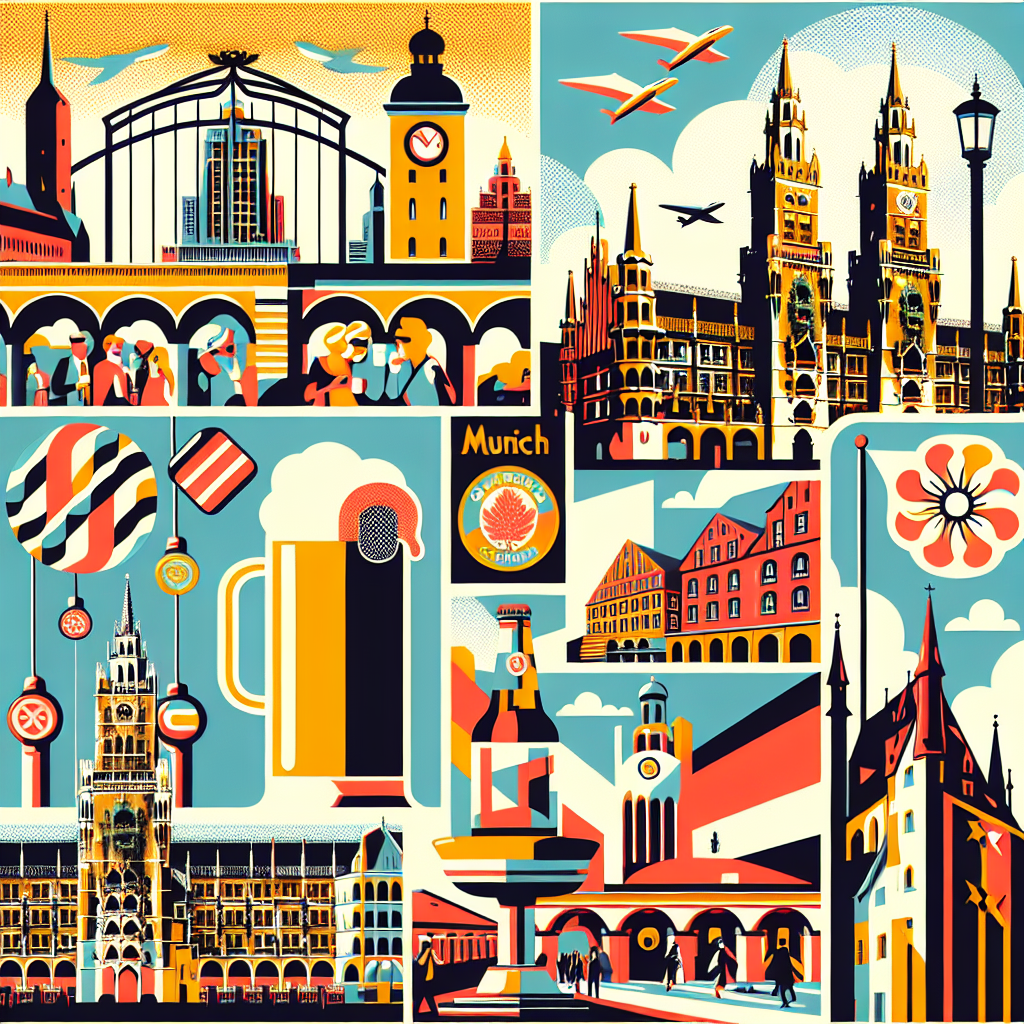

In [3]:
image = artist("Munich City")
display(image)

In [17]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [18]:
ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tools get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [19]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [20]:
tools = [{"type": "function", "function": price_function}]

In [21]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city, "price": price}),
        "tool_call_id": message.tool_calls[0].id
    }
    return response, city

In [27]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]
    
    return history, image

In [28]:
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")
        
        
    def do_entry(message, history):
        history += [{"role": "user", "content": message}]
        return "", history
    
    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)
    
ui.launch()

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


Tools get_ticket_price called for Berlin
